Generating synthetic data...
Data generated for 200 patients.

--- Processing Data ---
General Statistics on Waiting Time (Minutes):
count    200.00
mean      31.28
std       18.15
min        5.00
25%       18.00
50%       30.00
75%       41.25
max       90.00
Name: Waiting_Time_Min, dtype: float64

--- Department Bottlenecks (Sorted by Avg Wait) ---
                   mean  median  count
Department                            
Cardiology        50.89    48.0     47
Orthopedics       28.91    32.0     43
Pediatrics        24.94    26.0     31
ENT               23.46    25.5     46
General Medicine  23.33    26.0     33

Time Bottleneck: The highest average wait times occur for patients arriving at 15:00.

Generating Plots...


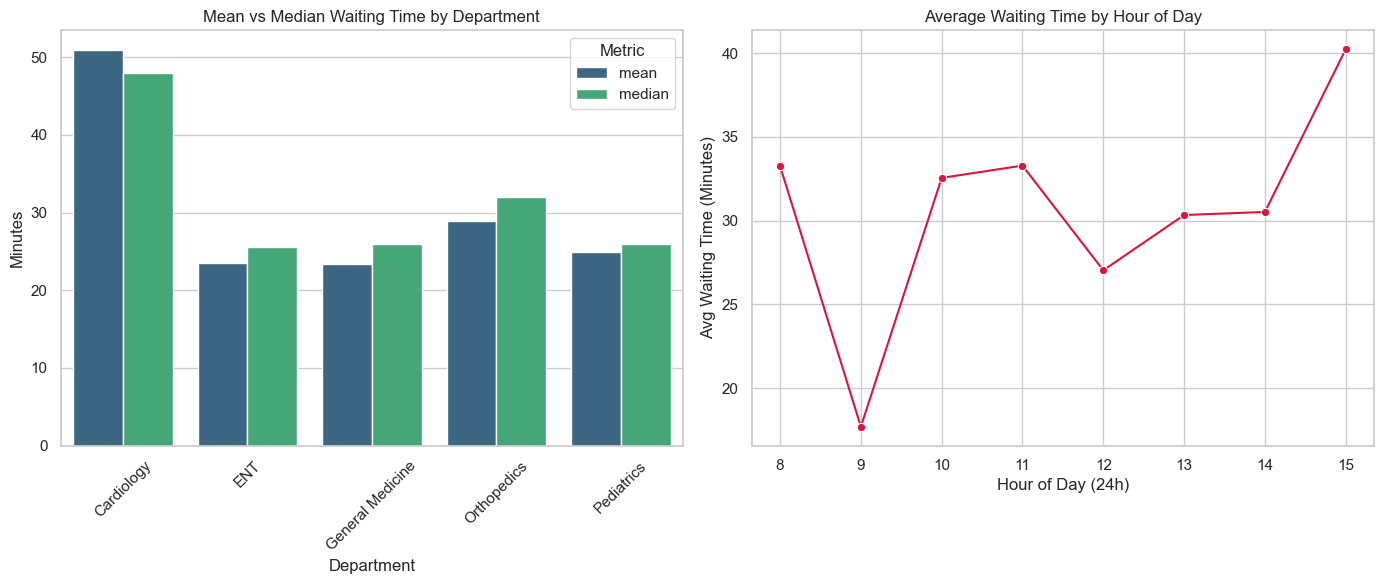

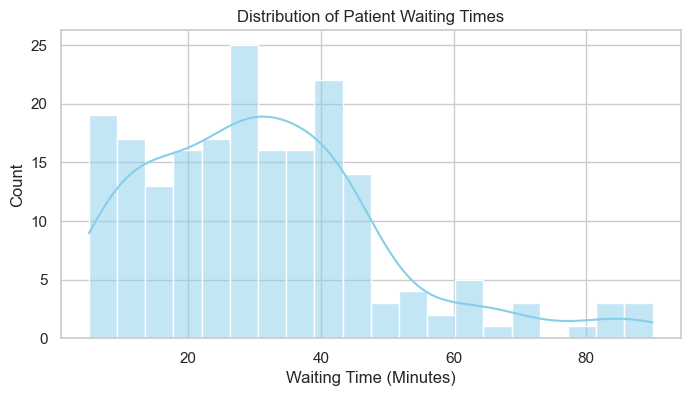

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import random

# --- CONFIGURATION ---
sns.set_theme(style="whitegrid")

# --- STEP 1: DATA GENERATION ---
def generate_hospital_data(num_patients=200):
    """Generates synthetic OPD data for analysis."""
    departments = ['Cardiology', 'Orthopedics', 'General Medicine', 'Pediatrics', 'ENT']
    data = []
    
    # Simulate a day starting at 8:00 AM
    base_time = datetime.strptime('2023-10-27 08:00:00', '%Y-%m-%d %H:%M:%S')
    
    for i in range(1, num_patients + 1):
        # Random department
        dept = random.choice(departments)
        
        # Random arrival time (spread across 8 hours)
        arrival_delay = random.randint(0, 480) # minutes
        arrival_time = base_time + timedelta(minutes=arrival_delay)
        
        # Appointment time is usually close to arrival or slightly before
        appt_time = arrival_time - timedelta(minutes=random.randint(-15, 30))
        
        # Waiting time logic: 
        # Cardiology has artificially higher wait times in this simulation for demo purposes
        wait_factor = 2 if dept == 'Cardiology' else 1
        wait_minutes = random.randint(5, 45) * wait_factor
        
        consultation_start = arrival_time + timedelta(minutes=wait_minutes)
        consultation_end = consultation_start + timedelta(minutes=random.randint(10, 30))
        
        data.append([i, dept, arrival_time, appt_time, consultation_start, consultation_end])
        
    df = pd.DataFrame(data, columns=[
        'Patient_ID', 'Department', 'Arrival_Time', 
        'Appointment_Time', 'Consultation_Start', 'Consultation_End'
    ])
    
    return df

# --- MAIN EXECUTION ---
if __name__ == "__main__":
    
    # 1. Load Data
    print("Generating synthetic data...")
    df = generate_hospital_data()
    print(f"Data generated for {len(df)} patients.")
    
    # 2. Preprocessing & Feature Engineering
    print("\n--- Processing Data ---")

    # Calculate Waiting Time (in minutes)
    df['Waiting_Time_Min'] = (df['Consultation_Start'] - df['Arrival_Time']).dt.total_seconds() / 60

    # Extract Hour of Arrival for trend analysis
    df['Arrival_Hour'] = df['Arrival_Time'].dt.hour

    # Categorize Wait Time
    def categorize_wait(minutes):
        if minutes < 15: return 'Low'
        elif minutes < 45: return 'Medium'
        else: return 'High'

    df['Wait_Category'] = df['Waiting_Time_Min'].apply(categorize_wait)

    # Display general stats
    print("General Statistics on Waiting Time (Minutes):")
    print(df['Waiting_Time_Min'].describe().round(2))

    # 3. Bottleneck Analysis
    # Group by Department to see which specialty is the slowest
    dept_analysis = df.groupby('Department')['Waiting_Time_Min'].agg(['mean', 'median', 'count']).sort_values(by='mean', ascending=False)

    print("\n--- Department Bottlenecks (Sorted by Avg Wait) ---")
    print(dept_analysis.round(2))

    # Identify the peak hour bottleneck
    hourly_analysis = df.groupby('Arrival_Hour')['Waiting_Time_Min'].mean()
    peak_hour = hourly_analysis.idxmax()
    print(f"\nTime Bottleneck: The highest average wait times occur for patients arriving at {peak_hour}:00.")

    # 4. Visualization
    print("\nGenerating Plots...")
    
    # Figure 1: Dashboard (Department Comparison + Hourly Trend)
    plt.figure(figsize=(14, 6))

    # Subplot 1: Bar Chart comparing Departments (Mean vs Median)
    plt.subplot(1, 2, 1)
    dept_metrics = df.groupby('Department')['Waiting_Time_Min'].agg(['mean', 'median']).reset_index()
    dept_metrics_melted = dept_metrics.melt(id_vars='Department', var_name='Metric', value_name='Minutes')

    sns.barplot(x='Department', y='Minutes', hue='Metric', data=dept_metrics_melted, palette='viridis')
    plt.title('Mean vs Median Waiting Time by Department')
    plt.xticks(rotation=45)
    plt.ylabel('Minutes')

    # Subplot 2: Line Plot for Hourly Trends
    plt.subplot(1, 2, 2)
    sns.lineplot(x='Arrival_Hour', y='Waiting_Time_Min', data=df, marker='o', color='crimson', errorbar=None)
    plt.title('Average Waiting Time by Hour of Day')
    plt.xlabel('Hour of Day (24h)')
    plt.ylabel('Avg Waiting Time (Minutes)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Figure 2: Distribution Plot (Histogram)
    # Note: Close the first window to see this second window appear
    plt.figure(figsize=(8, 4))
    sns.histplot(df['Waiting_Time_Min'], kde=True, bins=20, color='skyblue')
    plt.title('Distribution of Patient Waiting Times')
    plt.xlabel('Waiting Time (Minutes)')
    plt.show()